In [24]:
pip -q install numpy seaborn pandas nltk tensorflow-gpu torch matplotlib transformers Iprogress sentencepiece

Note: you may need to restart the kernel to use updated packages.


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import os
import random

2022-12-06 17:44:14.479603: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-06 17:44:15.241229: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/cuda/lib64:/opt/cuda/lib64:
2022-12-06 17:44:15.241316: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/cuda/lib64:/opt/cuda/lib64:
2022-12-06 17:44:15.241323: W tensorflow/compiler/tf2tensorrt/ut

## BBC News Summary EDA

Note: 199.txt in sports of the summaries and articles is disregarded due to corruption please remove these files to avoid mismatch in summaries and aricles count

In [3]:
def get_text_by_topic(directory_path):
    data = []
    count = 0
    for topic in os.listdir(directory_path):
        topic_path = os.path.join(directory_path, topic)
        for file_path in os.listdir(topic_path):
            try:
                with open(f'{topic_path}/{file_path}', 'r', encoding="utf-8") as f:
                    data.append(( topic_path.split('/')[-1],f.read()))
                count+=1
            except UnicodeDecodeError:
                print(f'file {file_path} in {topic_path} is not readable')
                print(UnicodeDecodeError)
    df = pd.DataFrame(data, columns=['label','text'])
    print(f"Total Items loaded: {count}")
    return df
                      
articles_path = r"data/BBC News Summary/News Articles"
summaries_path = r"data/BBC News Summary/Summaries"

articles_df = get_text_by_topic(articles_path)
summaries_df = get_text_by_topic(summaries_path)
articles_df.head()

Total Items loaded: 2224
Total Items loaded: 2224


,label,text
0,tech,British Library gets wireless net\n\nVisitors ...
1,tech,Solutions to net security fears\n\nFake bank e...
2,tech,Camera phones are 'must-haves'\n\nFour times m...
3,tech,Progress on new internet domains\n\nBy early 2...
4,tech,Supercomputer breaks speed record\n\nThe US is...


In [4]:
print("Articles Shape: ",articles_df.shape)
print("Summaries Shape: ",summaries_df.shape)
# If this fails the wrong number of aricles or summaries was loaded
assert(articles_df.shape == summaries_df.shape)

ex_idx = int(random.random()*articles_df.shape[0])
ex_topic = articles_df["label"][ex_idx]
print(f"\nRandom Example Article in {ex_topic}:")
print(articles_df["text"][ex_idx])
print(f"Random Example Summary in {ex_topic}:")
print(summaries_df["text"][ex_idx])

Articles Shape:  (2224, 2)
Summaries Shape:  (2224, 2)

Random Example Article in business:
Man Utd to open books to Glazer

Manchester United's board has agreed to give US tycoon Malcolm Glazer access to its books.

Earlier this month, Mr Glazer presented the board with detailed proposals on an offer to buy the football club. In a statement, the club said it would allow Mr Glazer "limited due diligence" to give him the opportunity to take the proposal on to a formal bid. But it said it continued to oppose Mr Glazer's plans, calling his assumptions "aggressive" and his plan "damaging". Many of Manchester United's supporters own shares in the club, and the fan-based group Shareholders United is strongly opposed to any takeover by Mr Glazer. About 300 fans protested outside the Old Trafford ground two days ago.

Rival local club Manchester City has pleaded with visiting fans not to protest inside its ground when the two teams play a televised match on Sunday.

Manchester United's respons

From this example we can see the dataset consists of BBC articles and co-responding summaries that are constructed in an extractive manner, that is, each summary is constructed by selecting a subset of the sentances in the original article.

In [5]:
# Null Checks
articles_df.isna().sum()
summaries_df.isna().sum()

label    0
text     0
dtype: int64

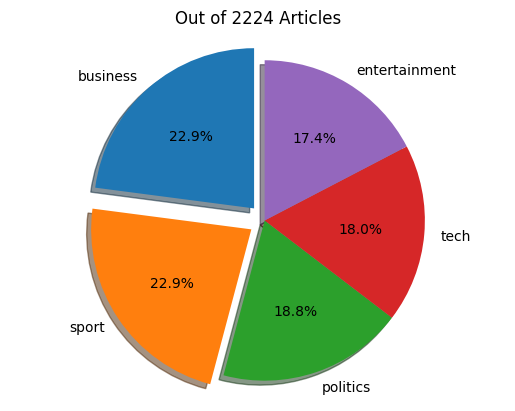

In [6]:
# Percent articles in each topic
label_vals = articles_df["label"].value_counts()

labels = list(label_vals.keys())
sizes = list(label_vals)
explode = [0]*len(sizes) 
explode[0] =0.1
explode[1] =0.1
fig1, ax1 = plt.subplots()
ax1.pie(label_vals, explode=explode, labels=labels, autopct='%1.1f%%',shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title(f"Out of {articles_df.shape[0]} Articles")
plt.show()


In [43]:
# Number of Sentances in articles per topic
text_lens = [[len(t.split(".")) for t in articles_df["text"][articles_df['label'] == label]] for label in articles_df['label'].unique()]

t_lengths = pd.DataFrame(text_lens).transpose()
t_lengths.columns = articles_df['label'].unique()
t_lengths.describe()

#plt.show()

,tech,business,politics,entertainment,sport
count,401.000000,510.000000,417.000000,386.000000,510.000000
mean,25.842893,19.680392,22.227818,17.945596,18.280392
std,12.904370,7.409560,15.467658,14.270836,9.876736
min,7.000000,7.000000,5.000000,8.000000,7.000000
25%,18.000000,14.000000,16.000000,12.000000,12.000000
50%,22.000000,18.000000,21.000000,14.000000,16.000000
75%,31.000000,23.000000,25.000000,20.000000,23.000000
max,161.000000,53.000000,246.000000,205.000000,82.000000


In [44]:
# Number of Words in articles per topic
text_lens = [[len(t.split(" ")) for t in articles_df["text"][articles_df['label'] == label]] for label in articles_df['label'].unique()]

t_lengths = pd.DataFrame(text_lens).transpose()
t_lengths.columns = articles_df['label'].unique()
t_lengths.describe()

,tech,business,politics,entertainment,sport
count,401.000000,510.000000,417.000000,386.000000,510.000000
mean,497.431421,324.670588,448.762590,326.326425,324.635294
std,236.977902,134.594878,296.311806,257.214463,185.461937
min,160.000000,138.000000,87.000000,141.000000,107.000000
25%,334.000000,230.000000,313.000000,221.250000,202.000000
50%,442.000000,294.000000,434.000000,259.000000,284.000000
75%,623.000000,383.000000,523.000000,356.000000,405.250000
max,2926.000000,881.000000,4377.000000,3408.000000,1646.000000


In [45]:
# Number of Characters in articles per topic
text_lens = [[len(t) for t in articles_df["text"][articles_df['label'] == label]] for label in articles_df['label'].unique()]

t_lengths = pd.DataFrame(text_lens).transpose()
t_lengths.columns = articles_df['label'].unique()
t_lengths.describe()

,tech,business,politics,entertainment,sport
count,401.000000,510.000000,417.000000,386.000000,510.000000
mean,2976.359102,1986.727451,2684.088729,1928.593264,1895.835294
std,1362.780889,816.435526,1714.424493,1462.113142,1068.761680
min,975.000000,848.000000,503.000000,825.000000,721.000000
25%,2047.000000,1412.250000,1879.000000,1314.750000,1189.000000
50%,2638.000000,1819.500000,2629.000000,1559.000000,1643.000000
75%,3752.000000,2373.750000,3149.000000,2103.750000,2332.500000
max,16160.000000,5408.000000,25485.000000,19138.000000,9473.000000


In [8]:
# Summary length reduction per topic

In [9]:
# Rarity of words used

In [10]:
# Overall use of stop words
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords


In [11]:
# Additional NLP statistics

## EDA on modified text

## Preprocessing For Extractive Text Summarization

In [12]:
# Remove stop words

# Remove Contractions and other anomolies

# Vectorize sentance

## Preprocessing For Abstractive Text Summarization

In [13]:
# Import tokenizer from pretrained model
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

model_name = "t5-small" # you can specify the model size here
tokenizer = AutoTokenizer.from_pretrained(model_name)

/home/nelly/.local/share/virtualenvs/Fall-akRgt48W/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/nelly/.local/share/virtualenvs/Fall-akRgt48W/lib/python3.8/site-packages/transformers/models/t5/tokenization_t5_fast.py:155: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-small automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this

In [14]:
MAX_INPUT_LENGTH = 512
MAX_TARGET_LENGTH = 30

def preprocess_function(articles, summaries):
    model_inputs = tokenizer(
        articles["text"],
        max_length=max_input_length,
        truncation=True,
    )
    labels = tokenizer(
        summaries["text"], max_length=max_target_length, truncation=True
    )
    model_inputs["labels"] = articles["labels"]
    return model_inputs

